Peak wavelength 6615.29 Å
Sigma 1.30256 Å
Error 0.26 Å
Distance from the centre 7.995 kpc


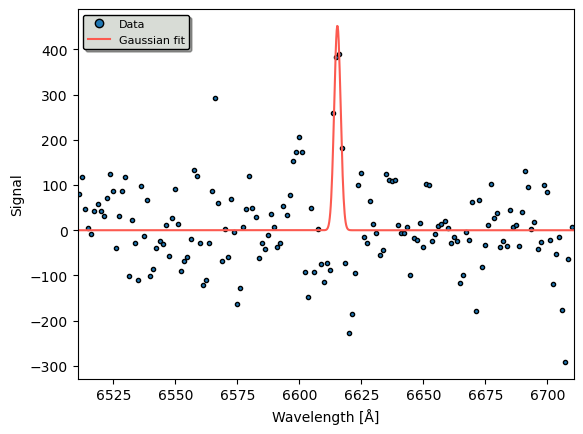

In [108]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import numpy as np
import matplotlib.pyplot as plt
import scipy.special
from astropy.io import fits
from scipy.optimize import curve_fit

plt.close('all')

###############################################################################
# The point of the program is to fit the wavelength of an emission line 
# - specifically the H-alpha line. Input is :
# 1) a wavelength calibrated 2-dimensional spectrum in the form of a fits-file. 
#    The fits file has a header with wavelength calibration information
#    The dispersion direction is along rows.
#
# 2) a file called "info.txt" with the following information:
#    the bin to fit
#    the fits-file name
#    kpc/arcsec at the redshift of the galaxy
#    the redshift
#    the row-number of the center of the galaxy
#    the binning factor (rows per bin)
#    the start-guess of the wavelength of the line
#    the start-guess of the sigma of the line
#
###############################################################################


###############################################################################


####################################
####  FUNCTION DEFINITIONS      ####                       
####################################

def gauss_function(x,I,mu,sigma):
    return I/(np.sqrt(2.0*np.pi)*sigma)*np.exp(-0.5*((x-mu)/sigma)**2)

###############################################################################


####################################
####       MAIN PROGRAMME       ####                       
####################################

#Read information in info.txt
file = open('/Users/samakshkaushik/Desktop/Projects/Dark-matter-in-spiral-galaxy/NGC5676/info.txt', 'r') 
n = int(file.readline())
filename = file.readline()
kpc_per_arc = float(file.readline())
z = float(file.readline())
ncenter = int(file.readline())
binSize = int(file.readline())
wlguess = float(file.readline())
sigguess = float(file.readline())

#Define Global constants
lmbd_em = 6564.61 # H-alpha wavelenght in AA
pixel_scale = 0.189 # arcsec per pixel
c = 3.0 * 10 ** 5 #speed of light [km/s]
G = 6.674 * 10**(-11) #NW gravitaional constant in SI units

#Load data and set up wavelength array
Galaxy = fits.open(filename.strip("\n"), ignore_missing_end=True)
header = Galaxy[0].header
data = Galaxy[0].data
ncol = len(data[0]) #number of coloumns in the data
bins = int(len(data)/binSize) #number of bins
#Read the wavelength calibration information from the header of the firs-file
cdelt1 = header['CDELT1'] #Increment, i.e. AA/pixel
crval1 = header['CRVAL1'] #Startwavelength in AA
wl = np.arange(crval1,ncol*cdelt1+crval1,cdelt1) #wavelength array in AA
distance = (n*binSize-ncenter)*pixel_scale*kpc_per_arc #distance from the center of the galaxy in kpc


####################################
####     BIN THE DATA           ####                       
####################################

flux = [] #Placeholder for the binned spectrum 
spec = [] #Placeholder for the flux as function of wavelength
x = np.array_split(data,bins,axis=0) #spatial division in bin size

for i in range(len(x)): # Sum flux in each bin of size 20
    flux.append(np.sum(x[i],axis=0))
for i in range(len(x)): # Join together flux and spectrum
    spec.append(np.vstack((flux[i],wl)))


####################################
####         DO THE FIT         ####                       
####################################

GoodRange = np.where( (wl >= (1+z)*lmbd_em-100.) & (wl <= (1+z)*lmbd_em+100.) )[0]
BackRangeLeft = np.where( (wl >= (1+z)*lmbd_em-100.) & (wl <= (1+z)*lmbd_em-30.) )[0]
BackRangeRight = np.where( (wl >= (1+z)*lmbd_em+30.) & (wl <= (1+z)*lmbd_em+100) )[0]
flux = flux[n]
meanBackLeft = np.mean(flux[BackRangeLeft])
meanBackRight = np.mean(flux[BackRangeRight])
meanBack = (meanBackLeft + meanBackRight) / 2.
flux = flux[GoodRange]- meanBack

Parameter_guesses = [np.max(flux),wlguess,sigguess] 
val, cov = curve_fit(gauss_function, wl[GoodRange], flux, p0=Parameter_guesses)

#"{:.6}".format(x)
print('Peak wavelength '+"{:.6}".format(val[1])+' Å')
print('Sigma '+"{:.6}".format(val[2])+' Å')
print('Error '+"{:.2}".format(np.sqrt(cov[1][1]))+' Å')
#print('Error '+str(np.sqrt(cov[1][1])) +' Å')
print('Distance from the centre '+"{:.4}".format(distance)+' kpc')


#####################################
####  PLOT THE LINE AND THE FIT  ####                       
#####################################

plt.figure()
plt.plot(wl[GoodRange], flux,'.',mec = 'k',label='Data')
plt.plot(np.linspace((1+z)*lmbd_em-100., (1+z)*lmbd_em+100., 1000), gauss_function(np.linspace((1+z)*lmbd_em-100., (1+z)*lmbd_em+100., 1000), *val),'-',c = '#fc5a50',\
         label='Gaussian fit')
plt.ylabel('Signal')
plt.xlabel('Wavelength [Å]')
plt.legend(loc='upper left', fancybox=True, shadow=True, framealpha= 1,\
    facecolor='#d8dcd6',edgecolor='black', prop={'size': 8}, markerscale=2)
plt.xlim((1+z)*lmbd_em-100., (1+z)*lmbd_em+100.)
plt.show()




In [106]:
import pandas as pd
import os

# Your data
data = {
    'Peak Wavelength': "{:.6}".format(val[1]),
    'Sigma': "{:.6}".format(val[2]),
    'Error': "{:.2}".format(np.sqrt(cov[1][1])),
    'Distance from the centre': "{:.4}".format(distance)
}

# Convert the data to a DataFrame
df = pd.DataFrame(data, index=[0])

# The name of your CSV file
filename = 'filename.csv'

# Check if the file exists
if os.path.isfile(filename):
    # If it exists, append without writing the header
    df.to_csv(filename, mode='a', header=False, index=False)
else:
    # If it doesn't exist, write the DataFrame to a CSV file with a header
    df.to_csv(filename, mode='w', header=True, index=False)